In [1]:
import os
import glob
import importlib
import numpy as np
import pandas as pd
import pylab as pl
import seaborn as sns

In [2]:
import analyze2p.gratings.utils as gutils
import analyze2p.plotting as pplot
import analyze2p.arousal.dlc_utils as dlcutils
import analyze2p.aggregate_datasets as aggr
import analyze2p.utils as hutils

In [3]:
#### Plotting params
visual_areas, area_colors = pplot.set_threecolor_palette()
pplot.set_plot_params(labelsize=6, lw_axes=0.25)
bw_colors = dict((v, [0.7]*3) for v in visual_areas)

In [4]:
%matplotlib notebook

In [6]:
#### Set trace ID and FOV/state type
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'
rootdir='/n/coxfs01/2p-data'
fov_type = 'zoom2p0x'
state = 'awake'
traceid = 'traces001'

experiment = 'gratings'
trial_epoch = 'plushalf'
responsive_test='nstds'
response_type='dff'
if responsive_test=='nstds':
    responsive_thr=7.0 if experiment=='rfs' else 10.
else:
    responsive_thr=0.05 if responsive_test=='ROC' else responsive_thr
resp_desc = '%s_responsive-%s-thr%.2f' \
                % (response_type, responsive_test, responsive_thr)
data_id = '|'.join([traceid, resp_desc])
print(data_id)
# ------------------------------------------------------------------
# Load all metdata and assigned cells
sdata, cells0 = aggr.get_aggregate_info(visual_areas=visual_areas, return_cells=True)
experiment_list = ['rfs10', 'rfs'] if experiment=='rfs' else [experiment]
meta = sdata[sdata.experiment.isin(experiment_list)].copy()
CELLS = pd.concat([g for (va, dk), g in cells0.groupby(['visual_area', 'datakey'])\
                if not meta.query('@va == visual_area and @dk == datakey').empty])
# Neural data
NDATA0 = aggr.load_responsive_neuraldata(experiment, traceid=traceid,
                      response_type=response_type, trial_epoch=trial_epoch,
                      responsive_test=responsive_test, 
                      responsive_thr=responsive_thr)
if experiment not in ['rfs', 'rfs10']: # assigned in load_responsive_neuraldata()
    NDATA0['experiment'] = experiment 

traces001|dff_responsive-nstds-thr10.00
/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 13 dsets
/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 13 dsets
...loading: /n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/aggr_gratings_trialmeans_traces001_nstds-thr-10.00_dff_plushalf.pkl
Checking gratings configs
    skipping: 20190306_JC061_fov2
    skipping: 20190319_JC067_fov1
    skipping: 20190314_JC070_fov1
    skipping: 20190314_JC070_fov2
    skipping: 20190315_JC070_fov2
    skipping: 20190513_JC078_fov1
    skipping: 20190511_JC083_fov1
    skipping: 20190512_JC083_fov1
    skipping: 20190517_JC083_fov1
    skipping: 20190522_JC089_fov1
    skipping: 20190527_JC092_fov3
... not in exp: 20190321_JC070_fov2


In [7]:
import _pickle as pkl
import analyze2p.decoding as dec

In [8]:
def get_iterdf(experiment, meta, 
                      analysis_type=None,
                      test_type=None,
                      traceid='traces001',
                      trial_epoch='stimulus', responsive_test='nstds', 
                      C_value=1, break_correlations=False, 
                      match_rfs=False, overlap_thr=None):

    iterdf=None; iterdf_b=None;
    missing_=None; missing_b=None;
    iterdf, missing_ = dec.aggregate_iterated_results(experiment, meta, 
                          analysis_type=analysis_type,
                          test_type=test_type,
                          traceid=traceid,
                          trial_epoch=trial_epoch, responsive_test=responsive_test, 
                          C_value=C_value, break_correlations=False, 
                          match_rfs=match_rfs, overlap_thr=overlap_thr)
    if test_type is None:
        iterdf_b, missing_b = dec.aggregate_iterated_results(experiment, meta, 
                              analysis_type=analysis_type,                   
                              test_type=test_type,
                              traceid=traceid,
                              trial_epoch=trial_epoch, responsive_test=responsive_test, 
                              C_value=C_value, break_correlations=False, 
                              match_rfs=match_rfs, overlap_thr=overlap_thr)
    return iterdf, missing_, iterdf_b, missing_b


In [10]:
def average_across_iterations(iterdf, iterdf_b=None, analysis_type='by_fov', 
                              test_type=None):
    cols=['visual_area', 'datakey', 'condition']
    cols.extend(['novel', 'train_transform', 'test_transform'])
    if analysis_type=='by_ncells':
        cols.append('n_cells')
    df_intact = iterdf.groupby(cols).mean().reset_index()
    df_intact['intact'] = True
    
    if iterdf_b is not None:
        df_nocc = use_df.groupby(cols).mean().reset_index()
        df_nocc['intact'] = False
        DF = pd.concat([df_intact, df_nocc], axis=0)
    else:
        DF = df_intact.copy()
    return DF

def average_within_iterations_by_ncells(iterdf, analysis_type='by_ncells', 
                              test_type='size_single'):
    iter_groupby=['visual_area', 'condition', 'n_cells', 'iteration']
    if test_type is not None:
        iter_groupby.extend(['novel'])

    mean_by_iters = iterdf.groupby(iter_groupby).mean().reset_index()
    return mean_by_iters


def average_across_iterations_by_fov(iterdf, analysis_type='by_fov', 
                              test_type='morph'):
    iter_groupby=['visual_area', 'condition', 'datakey']
    if test_type is not None:
        iter_groupby.extend(['novel', 'train_transform', 'test_transform', 'morphlevel'])

    mean_by_iters = iterdf.groupby(iter_groupby).mean().reset_index()
    return mean_by_iters


In [9]:
importlib.reload(dec)

<module 'analyze2p.decoding' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/decoding.py'>

In [54]:
analysis_type='by_ncells'

basedir = os.path.join(aggregate_dir, 'decoding', 'py3_%s' % analysis_type)
if not os.path.exists(basedir):
    os.makedirs(basedir)
    print(basedir)

In [55]:
test_type = None
match_rfs = False

trial_epoch = 'plushalf'
test_str = 'default' if test_type is None else test_type

C_value=1.0
test_split=0.2
cv_nfolds=5
overlap_thr=None
chance_level = 1/8. if experiment=='gratings' else 0.5

In [56]:
aggr_id = dec.create_aggregate_id(experiment, C_value=C_value, 
                                trial_epoch=trial_epoch,
                                responsive_test=responsive_test,
                                  match_rfs=match_rfs,
                                overlap_thr=None)
test_str = 'default' if test_type is None else test_type
curr_dst_dir = os.path.join(basedir, test_str, aggr_id)
if not os.path.exists(curr_dst_dir):
    os.makedirs(curr_dst_dir)
print(curr_dst_dir)

/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_by_ncells/default/gratings__dff-nstds__plushalf__noRF__C1.00


In [57]:
iterdf, missing_, iterdf_b, missing_b = get_iterdf(experiment, meta, 
                          analysis_type=analysis_type,
                          test_type=test_type,
                          traceid=traceid,
                          trial_epoch=trial_epoch, responsive_test=responsive_test, 
                          C_value=C_value, break_correlations=False, 
                          match_rfs=match_rfs, overlap_thr=overlap_thr)

(Li) Found 9 paths
(Lm) Found 4 paths
(V1) Found 0 paths
(Li) Found 9 paths
(Lm) Found 4 paths
(V1) Found 0 paths


In [58]:
print(analysis_type, test_type)
if analysis_type=='by_fov':
    mean_df = average_across_iterations_by_fov(iterdf,
                        analysis_type=analysis_type, test_type=test_type)
else:
    mean_df = average_within_iterations_by_ncells(iterdf, analysis_type=analysis_type,
                                                  test_type=test_type) 

if test_type is not None:
    print("novel:", mean_df['novel'].unique())
print("conditions:", mean_df['condition'].unique())

by_ncells None
conditions: ['data' 'shuffled']


In [59]:
cols = [ 'visual_area', 'n_cells'] if test_type=='by_ncells' else ['visual_area']
columns = None
if test_type is not None:
    score_table = mean_df[~(mean_df.novel) 
                               & (mean_df.condition=='data')]\
            .groupby(cols)\
            .mean()['heldout_test_score'].reset_index()\
            .pivot_table(index='visual_area', columns=columns)
else:
    score_table = mean_df[(mean_df.condition=='data')]\
            .groupby(cols)\
            .mean()['heldout_test_score'].reset_index()\
            .pivot_table(index='visual_area', columns=columns)
score_table

,heldout_test_score
visual_area,
Li,0.168364
Lm,0.154434


In [60]:
iterdf.groupby(['visual_area', 'datakey'])['iteration'].value_counts()

visual_area  datakey    iteration
Li           aggregate  0            18
                        1            18
                        2            18
                        3            18
                        4            18
                                     ..
Lm           aggregate  495           8
                        496           8
                        497           8
                        498           8
                        499           8
Name: iteration, Length: 1000, dtype: int64

In [63]:
if analysis_type=='by_fov':
    match_ncells=False

    all_counts = mean_df[['visual_area', 'datakey', 'n_cells']].drop_duplicates()

    max_ncells = all_counts.groupby('visual_area')['n_cells'].max().min() \
                    if match_ncells \
                    else all_counts.groupby('visual_area')['n_cells'].max().max() 
    min_ncells = all_counts.groupby('visual_area')['n_cells'].min().max() \
                    if match_ncells \
                    else 10
    print(min_ncells, max_ncells)


    fov_filter_str = 'matchNcells' if match_ncells else 'allcells'
    passdf = mean_by_fov[(mean_by_fov['n_cells']>=min_ncells) 
                        & (mean_by_fov['n_cells']<=max_ncells)].copy()
    counts = passdf[['visual_area', 'datakey', 'n_cells']].drop_duplicates()

    # Drop repeat FOVs based on N fits
    u_dkeys = aggr.drop_repeats(counts, criterion='max', colname='n_cells')

    finaldf= pd.concat([g for (va, dk), g in passdf.groupby(['visual_area', 'datakey'])\
                    if (va, dk) in u_dkeys])
    finaldf[['visual_area', 'datakey']].drop_duplicates()['visual_area'].value_counts()
else:
    finaldf = iterdf.copy()

In [71]:
iterdf.groupby(['visual_area', 'n_cells']).mean()

fit_time  score_time  test_score  train_score  \
visual_area n_cells                                                  
Li          1        0.045624    0.006541    0.127100     0.140798   
            2        0.048658    0.006510    0.130521     0.151605   
            4        0.055055    0.006429    0.133930     0.168909   
            8        0.069418    0.006082    0.138224     0.196172   
            16       0.114666    0.005687    0.143801     0.246739   
            32       0.232862    0.005246    0.150390     0.364760   
            64       0.341066    0.004280    0.154707     0.749667   
            96       0.180184    0.003601    0.159677     0.952441   
            128      0.054161    0.002924    0.164444     0.998350   
Lm          1        0.045392    0.006484    0.130582     0.142951   
            2        0.047436    0.006307    0.133987     0.154231   
            4        0.053375    0.006190    0.140806     0.173400   
            8        0.068067    0.006117    0.149622     0.205845   

                     heldout_test_score    C     randi  n_trials  iteration  \
visual_area n_cells                                                           
Li          1                  0.129105  1.0  4958.872   1272.32      249.5   
            2                  0.130730  1.0  5258.650   1265.92      249.5   
            4                  0.134156  1.0  5134.618   1254.40      249.5   
            8                  0.139559  1.0  4967.900   1219.84      249.5   
            16                 0.143895  1.0  4876.910   1159.68      249.5   
            32                 0.153406  1.0  4927.196   1057.28      249.5   
            64                 0.158707  1.0  5000.642    893.44      249.5   
            96                 0.161422  1.0  4999.464    771.84      249.5   
            128                0.168672  1.0  4987.202    677.12      249.5   
Lm          1                  0.131094  1.0  5039.944   1272.32      249.5   
            2                  0.134973  1.0  4938.266   1264.64      249.5   
            4                  0.141965  1.0  5130.388   1249.28      249.5   
            8                  0.150152  1.0  4981.294   1221.12      249.5   

                     randi_cells  
visual_area n_cells               
Li          1           4855.318  
            2           4852.438  
            4           5153.966  
            8           4856.052  
            16          5066.044  
            32          4921.668  
            64          5022.214  
            96          4949.548  
            128         5191.874  
Lm          1           5011.318  
            2           5317.476  
            4           4679.116  
            8           5210.600

<IPython.core.display.Javascript object>


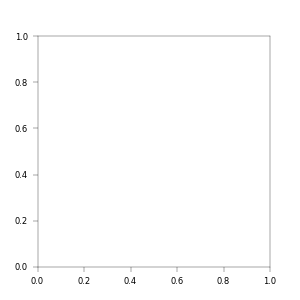

<AxesSubplot:xlabel='n_cells', ylabel='heldout_test_score'>

In [72]:
%matplotlib notebook
fig, axn = pl.subplots(figsize=(3,3))
sns.pointplot(x='n_cells', y='heldout_test_score', 
            data=iterdf[iterdf.condition=='data'],
           ax=ax, hue='visual_area') #, palette=area_colors, ci='sd')


In [44]:
cond_colors = {'data': [0.3]*3, 'shuffled': [0.7]*3}

<IPython.core.display.Javascript object>


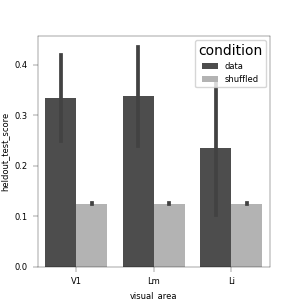

<AxesSubplot:xlabel='visual_area', ylabel='heldout_test_score'>

In [47]:
%matplotlib notebook
fig, ax = pl.subplots(figsize=(3,3))
sns.barplot(x='visual_area', y='heldout_test_score', data=finaldf,
           ax=ax, hue='condition', palette=cond_colors, ci='sd',
           order=visual_areas)

<IPython.core.display.Javascript object>


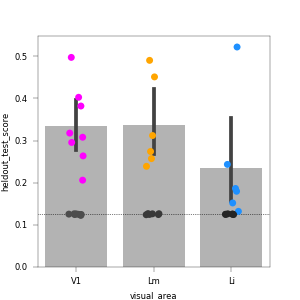

In [53]:
%matplotlib notebook
datad= finaldf[finaldf.condition=='data']
shuffd = finaldf[finaldf.condition=='shuffled']
fig, ax = pl.subplots(figsize=(3,3))
sns.stripplot(x='visual_area', y='heldout_test_score', data=datad,
               ax=ax, hue='visual_area', palette=area_colors,
               order=visual_areas)
sns.barplot(x='visual_area', y='heldout_test_score', data=datad,
               ax=ax, order=visual_areas, color=[0.7]*3)

sns.stripplot(x='visual_area', y='heldout_test_score', data=shuffd,
               ax=ax, hue='visual_area',  color=[0.3]*3,
               order=visual_areas)
ax.legend_.remove()
ax.axhline(y=chance_level, lw=0.5, ls=':', color='k')

# Example FOV

In [513]:
print(experiment)
dk = '20191006_JC110_fov1'
va = 'V1'

nmetrics = NDATA0[(NDATA0.visual_area==va) & (NDATA0.datakey==dk)].copy()

gratings


In [10]:
# dk = '20190616_JC097_fov1'
# va = 'V1'
print(experiment)
sdf = aggr.get_master_sdf(experiment)

blobs


In [11]:
class_name='morphlevel' if experiment=='blobs' else 'ori'
if experiment=='gratings':
    variation_name = None
else:
    variation_name = None if test_type is None else 'size'
variation_values=None
class_a = 0 if class_name=='morphlevel' else None
class_b = 106 if class_name=='morphlevel' else None
print(class_name, class_a, class_b)
class_values = [class_a, class_b] if class_name=='morphlevel' \
            else sdf[class_name].unique()
in_args={'class_name': class_name,
            'class_values': class_values,
            'variation_name': variation_name,
            'variation_values': variation_values,
            'n_train_configs': None,
            'C_value': C_value,
            'cv_nfolds': cv_nfolds,
            'test_split': test_split,
            'balance_configs':True,
            'do_shuffle': True,
            'return_clf': False,
            'verbose': False}

morphlevel 0 106


In [514]:
# stimuli
sdf = aggr.get_stimuli(dk, experiment)
# zscore data
ndf_z = aggr.get_zscored_from_ndf(nmetrics)
n_cells = int(ndf_z.shape[1]-1) 
print("... BY_FOV [%s] %s, n=%i cells" % (va, dk, n_cells))

... BY_FOV [V1] 20191006_JC110_fov1, n=93 cells


In [523]:
import copy
inargs = copy.copy(clf_params)

In [525]:
inum=3
test_type=None
i_df = dec.select_test(inum, test_type, ndf_z, sdf, **inargs)
i_df

... 3 - selecting


,fit_time,score_time,test_score,train_score,heldout_MI,heldout_aMI,heldout_log2MI,heldout_test_score,C,randi,condition,n_cells,n_trials,iteration
3,0.472028,0.010411,0.255849,0.835691,0.289775,0.094974,0.418057,0.304688,1.0,606,data,93,1280,3
3,1.024186,0.010827,0.127958,0.648679,0.079508,-0.012930,0.114706,0.136719,1.0,606,shuffled,93,1280,3


In [509]:
importlib.reload(dec)

<module 'analyze2p.decoding' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/decoding.py'>

In [538]:
neuraldf = ndf_z.copy()
tvals = neuraldf.index.tolist()
neuraldf.loc[neuraldf.index, 'trial'] = tvals         


In [526]:
res = dec.fit_svm_mp(ndf_z, sdf, None, n_iterations=10, n_processes=1,
              **clf_params)

... 0 - selecting
--> Elapsed time: 12.50sec
... 1 - selecting
--> Elapsed time: 12.42sec
... 2 - selecting
--> Elapsed time: 12.68sec
... 3 - selecting
--> Elapsed time: 11.49sec
... 4 - selecting
--> Elapsed time: 13.12sec
... 5 - selecting
--> Elapsed time: 12.25sec
... 6 - selecting
--> Elapsed time: 12.25sec
... 7 - selecting
--> Elapsed time: 11.91sec
... 8 - selecting
--> Elapsed time: 11.87sec
... 9 - selecting
--> Elapsed time: 12.10sec


In [365]:
inum =2
res = dec.do_fit_within_fov(inum, curr_data=ndf_z, sdf=sdf, 
                     C_value=C_value, test_split=test_split, cv_nfolds=cv_nfolds,
                     class_name=class_name, class_a=class_a, class_b=class_b, 
                     do_shuffle=True, balance_configs=True, return_clf=False)


/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/aggregate_datasets.py:1182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  drop_trial_col = True


In [323]:
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn import preprocessing
import sklearn.svm as svm
import sklearn.metrics as skmetrics

In [324]:
curr_data = ndf_z.copy()

In [325]:
#train_configs = sdf.index.tolist() 
train_configs = sdf[sdf[class_name].isin(classes)].index.tolist()

In [326]:
sample_data = curr_data[curr_data['config'].isin(train_configs)]
sample_data = aggr.equal_counts_df(sample_data)
sample_data

cell,0,5,7,18,19,23,28,29,31,32,...,269,281,288,301,302,312,313,320,328,config
trial,,,,,,,,,,,,,,,,,,,,,
1,0.078445,3.518986,2.386371,2.065101,1.772836,2.844329,6.966225,2.896976,0.653192,10.089535,...,-0.164878,8.258746,2.634527,2.821428,2.481068,0.051350,4.542824,2.827181,3.383868,config026
2,-1.152818,2.411491,-1.177954,-1.545042,-0.570205,-1.209613,-2.667617,1.343814,0.083505,4.195097,...,0.485428,2.386171,0.460740,-1.567966,0.821425,2.398091,0.324374,0.870920,1.180770,config010
3,0.653396,-0.478914,1.738281,0.001385,0.050060,0.559490,0.375340,-0.152469,-0.746372,-2.348391,...,-1.453632,-0.395428,-1.813270,-0.891581,-0.165115,-0.872763,-0.717911,-1.029094,-0.618699,config064
4,0.185509,3.109562,1.258647,1.130251,3.139119,2.926035,1.981328,2.537235,3.525917,3.392522,...,0.600094,3.968396,-2.109809,3.060546,2.697869,1.365633,1.174444,-0.252590,-0.690846,config049
5,0.078475,0.641078,-0.774927,0.050371,0.160926,0.657146,1.224734,-0.247175,-0.125525,-0.307120,...,-0.120079,-0.518387,1.194934,0.557252,-0.521050,-1.567678,-0.070270,-0.935974,-1.906833,config016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1276,-0.908171,-1.047119,-0.665546,-0.792583,-0.189404,-0.488754,-0.217741,0.785077,-1.084245,-0.527047,...,1.143603,-0.249548,0.400215,-1.178330,-0.037441,-0.708547,-0.409609,-1.561999,1.337479,config036
1277,-0.950673,0.268023,-0.629667,-0.320041,-0.581986,-0.839074,-0.043377,0.029160,0.095245,0.118334,...,-0.134356,-0.735776,-0.139399,-0.779681,0.012811,-0.048304,-0.166939,0.786257,-0.632552,config020
1278,0.689772,-0.785139,-0.222806,-0.573672,-0.244134,0.766249,-0.241643,-0.316434,-0.208946,0.138407,...,0.189678,0.926258,1.687781,0.384967,0.557723,0.457051,0.216065,-0.821144,-0.463522,config046


In [367]:
test = sample_data.drop('config', 1)
test.shape, sample_data.shape


((1280, 93), (1280, 94))

In [371]:
(test.values - zdata.values).max()


0.0

In [347]:
targets = pd.DataFrame(sample_data['config'].copy(), columns=['config'])
targets['label'] = sdf.loc[targets['config'].values][class_name].astype(int).values

In [348]:
rois_ = [r for r in sample_data.columns if hutils.isnumber(r)]
zdata= sample_data[rois_].copy()
len(rois_), zdata.shape

(93, (1280, 93))

In [352]:
randi=100
clf_params={'C_value': C_value,
            'cv_nfolds': cv_nfolds,
            'test_split': test_split,
            'randi': randi,
            'return_clf': False,
            'verbose': False}

In [353]:
citer = dec.fit_svm(zdata, targets, **clf_params)

In [354]:
citer

{'fit_time': 0.4293060779571533,
 'score_time': 0.009502601623535157,
 'test_score': 0.2627116212338594,
 'train_score': 0.8334923612972392,
 'heldout_MI': 0.25045956622441773,
 'heldout_aMI': 0.07479709081582958,
 'heldout_log2MI': 0.3613367741351682,
 'heldout_test_score': 0.25390625,
 'C': 1.0,
 'randi': 100}

In [329]:

train_data, test_data, train_labels, test_labels = train_test_split(zdata,
                                                            targets['label'].values,
                                                            test_size=test_split,
                                                            stratify=targets['label'],
                                                            shuffle=True,
                                                            random_state=randi)


In [330]:
pd.DataFrame(train_labels).value_counts()

0      128
45     128
90     128
135    128
180    128
225    128
270    128
315    128
dtype: int64

In [331]:
scaler = preprocessing.StandardScaler().fit(train_data)
train_data = scaler.transform(train_data)
svc_ = svm.SVC(kernel='linear', C=C_value, random_state=randi,
              decision_function_shape='ovr')

In [332]:
scores = cross_validate(svc_, train_data, train_labels, cv=5,
                        scoring=('accuracy'), 
                        return_train_score=True)
scores


{'fit_time': array([0.47146988, 0.47107625, 0.38281775, 0.44801259, 0.41353726]),
 'score_time': array([0.01139474, 0.00999784, 0.00940156, 0.00930309, 0.00928378]),
 'test_score': array([0.28780488, 0.27317073, 0.25853659, 0.21463415, 0.27941176]),
 'train_score': array([0.84249084, 0.83394383, 0.81929182, 0.82295482, 0.84878049])}

In [333]:
trained_svc = svc_.fit(train_data, train_labels)

In [334]:
test_data = scaler.transform(test_data)
test_score = trained_svc.score(test_data, test_labels)
predicted_labels = trained_svc.predict(test_data)


<IPython.core.display.Javascript object>


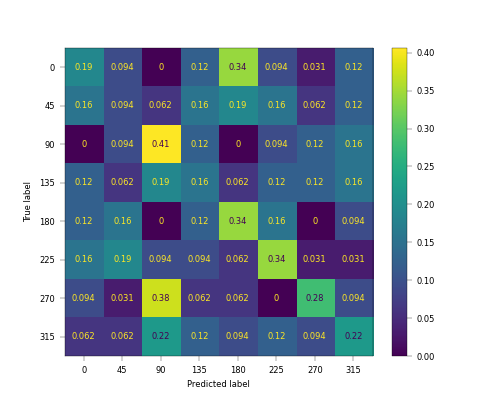

In [341]:
skmetrics.plot_confusion_matrix(trained_svc, test_data, test_labels, 
                                normalize='true')  

In [11]:
def wraper_func(func, **kwargs):
    output = func(**kwargs)
    return output

In [20]:
def func1(x='Func1', y='Alt1', z='Extra1'):
    res = '%s_%s_%s' % (x, y, z)
    return res

def func2(x='Func2', y='Alt2', w='Extra2'):
    res = '%s_%s_%s' % (x, y, z)
    r2 = 'andthis'
    return res, r2

In [23]:
inargs = {'x': 'check1', 'z': 'check2'}
inargs = (x='check1', y='check2')
res = wraper_func(func1, **inargs)
res

SyntaxError: invalid syntax (<ipython-input-23-0a6f99e4a23c>, line 2)

In [22]:
res = wraper_func(func2, **inargs)
res

TypeError: func2() got an unexpected keyword argument 'z'

In [ ]:
decode_from_fov(dk, va, neuraldf, sdf, C_value=C_value,
                        n_iterations=n_iterations, n_processes=n_processes, results_id=results_id,
                        class_a=class_a, class_b=class_b, do_shuffle=do_shuffle,
                        rootdir=rootdir, verbose=verbose,
                        test_type=test_type, n_train_configs=n_train_configs) 
            print("--- done by_fov ---")